In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import scipy.sparse.linalg as sla
from scipy.linalg import eig
from tqdm import tqdm
import pickle 
from pfapack import pfaffian as pf
from scipy.fft import ifftn
import dask.array as da

In [2]:
#first of all write real space one and get MLWF through PxP method 
#after that write BdG and understand how to compute topo invariant from there
#can we do Wilson loops? Wilson loops are extracted by the Bloch wavefunctions of the model (eigenfunctions in k space)
#we can't because this is BdG hamiltonian and apparently you have to use winding or chern (not existing in 1D) so 
#basically winding seems to be only way

In [3]:
k,A,G=np.pi/6,0.875,0.2635


N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) #checked
N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) #checked
Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) #checked
S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2)  #checked
S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k))  #checked





print("N1=",N1,"N2=",N2,"Hm=",Hm,"S1=",S1,"S2=",S2)

N1= -0.1519034536588329 N2= -2.1141155179225284 Hm= (-0.07548147470329514-0.004818490239785586j) S1= -0.48293317722216567 S2= (0.11149663092729029+0.0073661077120277954j)


In [27]:
#Define Hamiltonian, choose random k value, evaluate for A, G and test if PH operator sigmax cross sigmax flips its sign

def H(k,A,G):
    
    N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) #checked
    N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) #checked
    Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) #checked
    S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2)  #checked
    S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k))  #checked
    
    eps1,eps2,d=0.5,0.5,0  
    
    H = np.zeros((4,4), dtype=complex)
    H[0,0]=N1      +eps1
    H[0,1]=Hm      +d*np.exp(1j*k)
    H[0,2]=S1
    H[0,3]=S2
    H[1,0]=Hm.conj()    +d*np.exp(-1j*k)
    H[1,1]=N2      +eps2
    H[1,2]=S2.conj()
    H[1,3]=-S1
    H[2,0]=S1
    H[2,1]=S2
    H[2,2]=-N1      -eps1
    H[2,3]=-Hm      -d*np.exp(1j*k)
    H[3,0]=S2.conj()
    H[3,1]=-S1
    H[3,2]=-Hm.conj()          -d*np.exp(-1j*k)
    H[3,3]=-N2           -eps2
    
    return(H)

def magical(k,A,G):
    #magic Unitary
    U = np.array([[1,1],[1j,-1j]], dtype='complex128')
    U = np.kron(U,np.eye(2))
    magic = (1/2)*(U@U)
    return (magic@H(k,A,G)@magic.conj().T)[:2, 2:]

id=np.array([[1,0],[0,1]])
sigma_x=np.array([[0,1],[1,0]])
sigma_z=np.array([[1,0],[0,-1]])


In [28]:
k,G,A=np.pi/3,1.2432,0.243
print(magical(k,A,G))

[[-0.8464899 +0.61189893j  0.27129314-1.46552272j]
 [-0.11008023+0.80072005j -5.01511077-0.61189893j]]


In [29]:
C1 = np.kron(sigma_z,np.eye(2))
C2= np.kron(sigma_x,np.eye(2))
C3=C2@C1
#verify commutation relations 
#time reversal
print('Time reversal C1 is',np.allclose(C1@H(-1,2,1).conj()@C1,H(1,2,1)))

#PH symmetry
print('PH C2 is',np.allclose(C2@np.conj(H(0.1,2,1))@C2+H(-0.1,2,1),0*np.eye(4)))

#weird chiral
print('Mysterious chiral C3=C2C1 is',np.allclose(C3@H(0.1,2,1)@C3,H(0.1,2,1)))

Time reversal C1 is True
PH C2 is True
Mysterious chiral C3=C2C1 is True


In [30]:
C2@C2

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [31]:
#hermiticity check
np.allclose(H(1,1,1).conj().T-H(1,1,1),0*np.eye(4))

True

In [32]:
#unitarity check (not expected in BdG basis)
np.allclose(H(1,1,1)@H(1,1,1).conj().T,np.eye(4))

False

In [33]:
#verify if U2@C2@U2=sigma_z
U = np.array([[1,1],[1j,-1j]], dtype='complex128')
U = np.kron(U,np.eye(2))
magic = (1/2)*(U@U)
magic@C2@magic.conj().T

array([[0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]])

In [34]:
#consistency check
k=1;a=1;g=1
print(H(k,a,g)[0,0]+H(k,a,g)[2,2]) #check a
print(H(k,a,g)[0,1]-np.conj(H(k,a,g)[1,0])+H(k,a,g)[2,3]-np.conj(H(k,a,g)[3,2])) #check delta
print(H(k,a,g)[0,2]-np.conj(H(k,a,g)[2,0])+H(k,a,g)[3,1]-H(k,a,g)[1,3]) #check eta
print(H(k,a,g)[1,1]+H(k,a,g)[3,3]) #check beta
print(H(k,a,g)[0,3]-np.conj(H(k,a,g)[1,2])+H(k,a,g)[2,1]-np.conj(H(k,a,g)[3,0]))

0j
0j
0j
0j
0j


In [35]:
#chiral index
k_res=0.001
a_range = np.arange(0.00001,3.1,0.025)
g_range = np.arange(-2,2,0.025) 
k_range = np.arange(-np.pi, np.pi, k_res)

#trying original formula 
A1 = np.zeros((len(a_range),len(g_range)), dtype='c16')

for m,a in enumerate(tqdm(a_range)):
    
    for n,g in enumerate(g_range):
        
        v=np.zeros(len(k_range),dtype='c16')

        for i,k in enumerate(k_range):
            
            
            
            inv = (np.linalg.inv(magical(k,a,g)))
            der = (1/(2*k_res))*(magical(k+k_res,a,g)-magical(k-k_res,a,g))
            temp = inv@der
            v[i]= np.trace(temp)
           
        v_tot=(k_res)*(1/(2*np.pi*1j))*np.sum(v,axis=0)  
   
        A1[m,n]=v_tot
    



100%|██████████████████████████████████████████████████████████████████████████████| 124/124 [6:30:07<00:00, 188.77s/it]


Text(0, 0.5, '$\\gamma$')

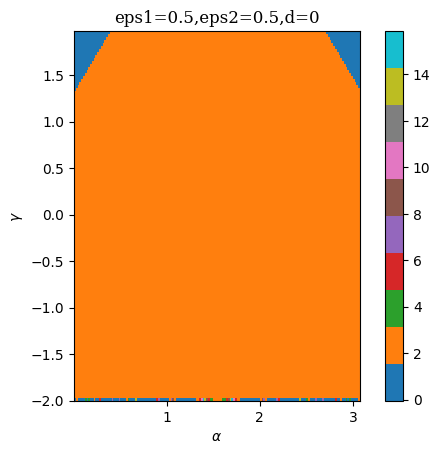

In [38]:
csfont = {'fontname':'Serif'}
x,y = a_range, g_range 
grid=np.real(np.flipud(A1))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='none',cmap='tab10')

fig.colorbar(cax)
plt.title('eps1=0.5,eps2=0.5,d=0',**csfont)
plt.xlabel(r'$\alpha$',**csfont)
#plt.ylim(-1.5,1.5)
plt.ylabel(r'$\gamma$',**csfont)


In [39]:
#saving data
with open('A e=0.5,d=0,  '+str(k_res)+'=k_res.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(A1, file)

In [211]:
#ph index

k_res=0.001
a_range = np.arange(0.00001,3,0.3)
g_range = np.arange(-3,3,0.3) 
k_range = np.arange(-np.pi, np.pi, k_res)

#trying original formula 
A2 = np.zeros((len(a_range),len(g_range)), dtype='c16')

for m,a in enumerate(tqdm(a_range)):
    
    for n,g in enumerate(g_range):
        
        v=np.zeros(len(k_range),dtype='c16')

        for i,k in enumerate(k_range):
            
            
            
            inv = (np.linalg.inv(H(k,a,g)))
            der = (1/(2*k_res))*(H(k+k_res,a,g)-H(k-k_res,a,g))
            temp = C2@inv@der
            v[i]= np.trace(temp)
           
        v_tot=(k_res)*(1/(4*np.pi*1j))*np.sum(v,axis=0)  
   
        A2[m,n]=v_tot
    


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:19<00:00, 13.94s/it]


Text(0, 0.5, '$\\gamma$')

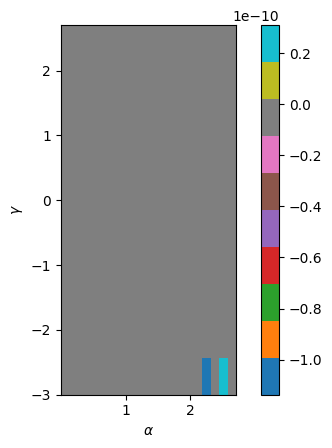

In [212]:
csfont = {'fontname':'Serif'}
x,y = a_range, g_range 
grid=np.real(np.flipud(A2))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='none',cmap='tab10')

fig.colorbar(cax)
#plt.title('eps=0.1,d=0',**csfont)
plt.xlabel(r'$\alpha$',**csfont)  
plt.ylabel(r'$\gamma$',**csfont)


In [15]:
print(np.real(A[(np.real(A)>-1.1) & (np.real(A)<-0.9)]).shape)

(203,)


In [ ]:
[0.99395332 0.97584165 1.00140052 1.00576721 0.95605754 0.89031403
 0.78424624 0.95767056 0.9903091  1.0074031  0.90849203 0.79584789
 0.64995997 0.87078407 0.50275644 0.50122099 0.59507335 0.72464256
 0.84844668 0.93920658 0.99452473 0.81313981 0.6591559  0.50399022
 1.03900244 0.61594129 0.61906087 0.76996904 0.90057121 0.67129949
 0.50981907 0.50981351 0.67129363 0.68957893 0.51662012 0.57111792
 0.52566931]

In [504]:
k_res=0.01   #circa 8 ore per 1e-5 res
a_range = np.arange(0.01,3,0.2)
g_range = np.arange(-2,2,0.2) 
k_range = np.arange(-np.pi, np.pi, k_res)

#trying derivative of logdet
A = np.zeros((len(a_range),len(g_range)), dtype='c16')

for m,a in enumerate(tqdm(a_range)):
    
    for n,g in enumerate(g_range):
        
        v=np.zeros(len(k_range),dtype='c16')
        der1=np.zeros(len(k_range),dtype='c16')
        der2=np.zeros(len(k_range),dtype='c16')
        der3=np.zeros(len(k_range),dtype='c16')
        der4=np.zeros(len(k_range),dtype='c16')
        
        for i,k in enumerate(k_range):
            
            _,der1[i]=(np.linalg.slogdet(H(k+k_res,a,g)))
            _,der2[i]=(np.linalg.slogdet(H(k-k_res,a,g)))
            _,der3[i]=(np.linalg.slogdet(H(k+2*k_res,a,g)))
            _,der4[i]=(np.linalg.slogdet(H(k-2*k_res,a,g)))
            
            
            v[i]=(1/(k_res*12))*(-der3[i]+8*der1[i]-8*der2[i]+der4[i]) 
                
            #numerical derivative above might be the problem due to singularities 
            #tried new derivative method with error of order k_res**5
           
        v_tot=(k_res)*(1/(4*np.pi*1j))*np.sum(v,axis=0) 
   
        A[m,n]=v_tot
    



100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.17s/it]


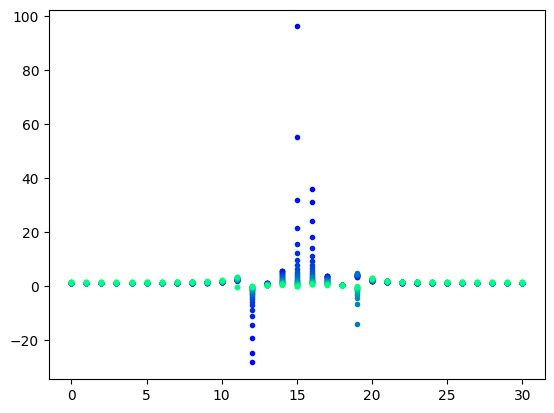

In [24]:
from mpl_toolkits.mplot3d import Axes3D

colormap = plt.cm.get_cmap('winter', len(Data3[1]))
ranger=np.zeros(len(Data3[1]))

for n,_ in enumerate(ranger):
    color = colormap(n)
    plt.plot(np.real(Data3[:,n]),'.',color=color)



#plt.ylim(-6,6)

In [383]:
#saving data
with open('A_bruteforce_'+str(k_res)+'=k_res.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(A, file)

## magic unitary + pfaffian + offdiagonal 

In [67]:
#magic Unitary

U = np.array([[1,1],[1j,-1j]], dtype='complex128')
U = np.kron(U,id)
magic = (1/2)*(U@U)
print(magic)

[[ 0.5+0.5j  0. +0.j   0.5-0.5j  0. +0.j ]
 [ 0. +0.j   0.5+0.5j  0. +0.j   0.5-0.5j]
 [ 0.5+0.5j  0. +0.j  -0.5+0.5j  0. +0.j ]
 [ 0. +0.j   0.5+0.5j  0. +0.j  -0.5+0.5j]]


In [844]:
k_res=0.01
a_range = np.arange(0.01,3,0.4)
g_range = np.arange(-2,2,0.4) 
k_range = np.arange(-np.pi, np.pi, k_res)

#trying original formula 
A_new = np.zeros((len(a_range),len(g_range)), dtype='c16')

for m,a in enumerate(tqdm(a_range)):
    
    for n,g in enumerate(g_range):
        
        something1=np.zeros(len(k_range),dtype='c16')
        something2=np.zeros(len(k_range),dtype='c16')


        for i,k in enumerate(k_range):
            
    
            offdiag1=magic@H(k+k_res,a,g)@np.conj(magic.T)
            offdiag2=magic@H(k-k_res,a,g)@np.conj(magic.T)
            #offdiag3=magic@H(k,a,g)@np.conj(magic.T)
            
            temp1=offdiag1[0:2, 2:4]
            temp2=offdiag2[0:2, 2:4]
            #temp3=offdiag3[0:2, 2:4]
            
            eigvalsL,_=np.linalg.eig(temp1)
            eigvalsR,_=np.linalg.eig(temp2)
            #eigvals3,_=np.linalg.eig(temp3)
            
            something1[i]=(1/2*k_res)*(eigvalsL[0]-eigvalsR[0])
            something2[i]=(1/2*k_res)*(eigvalsL[1]-eigvalsR[1])
            #raise KeyboardInterrupt
            
        vtot=(1/(2*np.pi*1j))*k_res*(np.sum(something1,axis=0)+np.sum(something2,axis=0))
        A_new[m,n]=vtot

100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.67it/s]


In [291]:
def offdiagonal(k_res,a,g):
    
    k_range = np.arange(-np.pi, np.pi, k_res)
    rot1=np.zeros(len(k_range))
    rot2=np.zeros(len(k_range))
    rot3=np.zeros(len(k_range))
    rot4=np.zeros(len(k_range))
    
    vec01=np.zeros((len(k_range),4))
    vec02=np.zeros((len(k_range),4))
    vec11=np.zeros((len(k_range),4))
    vec12=np.zeros((len(k_range),4))
    
    
    
    for i,k in enumerate(k_range):
        
        offdiag=magic@H(k,a,g)@np.linalg.inv(magic)
        temp1=offdiag1[0:2, 2:4]
        temp2=offdiag1[2:4, 0:2]
        _,eigvecs1 = np.linalg.eigh(temp1)
        _,eigvecs2 = np.linalg.eigh(temp2)
        
        vec01[i,:]=np.concatenate(([0,0],eigvecs1[:,0]))
        vec02[i,:]=np.concatenate(([0,0],eigvecs1[:,1]))
        vec11[i,:]=np.concatenate((eigvecs2[:,0],[0,0]))
        vec12[i,:]=np.concatenate((eigvecs2[:,1],[0,0]))
        
        #temp1=magic@vec1
        #temp2=magic@vec2
        #print(temp1)
        #rot1[i]=vec01.conj().T@vec01
        #rot2[i]=vec02.conj().T@vec02
        #rot3[i]=vec11.conj().T@vec11
        #rot4[i]=vec12.conj().T@vec12
        #print(rot1[i])
    #print(i)    
    #return rot1,rot2,rot3,rot4  
    return vec01,vec02,vec11,vec12

In [334]:
k_range = np.arange(-np.pi, np.pi, k_res)
#plt.plot(ifftn(offdiagonal(0.01,2,1)[0]),'x')
#plt.plot(offdiagonal(0.01,2,1)[1],'.')


H(-np.pi,2,1)@offdiagonal(0.01,2,1)[0][0,:]

eigvals,_=np.linalg.eigh(H(-np.pi,2,1))
print(eigvals)
eigv=eigvals[3]
if np.allclose(H(-np.pi,2,1)@offdiagonal(0.01,2,1)[0][0,:],eigv*magic@offdiagonal(0.01,2,1)[0][0,:]):
    print("v is an eigenvector with eigenvalue λ =", eigv)
else:
    print("v is not an eigenvector with eigenvalue λ =", eigv)

[-4.99734888 -0.00862319  0.00862319  4.99734888]
v is not an eigenvector with eigenvalue λ = 4.997348877874962


/tmp/ipykernel_54/1394628352.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  vec01[i,:]=np.concatenate(([0,0],eigvecs1[:,0]))
/tmp/ipykernel_54/1394628352.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  vec02[i,:]=np.concatenate(([0,0],eigvecs1[:,1]))
/tmp/ipykernel_54/1394628352.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  vec11[i,:]=np.concatenate((eigvecs2[:,0],[0,0]))
/tmp/ipykernel_54/1394628352.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  vec12[i,:]=np.concatenate((eigvecs2[:,1],[0,0]))


In [280]:
offdiagonal(0.01,2,1)[0][0]

/tmp/ipykernel_54/3390663698.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  rot1[i]=vec01.conj().T@vec01
/tmp/ipykernel_54/3390663698.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  rot2[i]=vec02.conj().T@vec02
/tmp/ipykernel_54/3390663698.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  rot3[i]=vec11.conj().T@vec11
/tmp/ipykernel_54/3390663698.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  rot4[i]=vec12.conj().T@vec12


0.9999999999999996

# coefficients test and spectrum

In [39]:
def aa(k,A,G):
    a = -(1/A)*((np.cosh(G)**(2))*((1/(np.cosh(2*G)))**(3))*((2*np.cosh(4*G)+np.sinh(4*G))*(-1+np.tanh(2*G))-2*np.cos(k)*np.tanh(2*G)))
    return a
aa(1,1,1)

0.17832798897867638

In [40]:
def b(k,A,G):
    b=(1/2*A)*(np.cosh(G)**(2))*((1/(np.cosh(2*G)))**(4))*(3*np.exp(-2*G)+np.exp(6*G)-8*np.cos(k)*np.cosh(G)*np.sinh(G))
    return b
b(1,1,1)

2.353276468689484

In [41]:
def eta(k,A,G):
    eta=(-1/2)*(1/(np.cosh(2*G)))**(2)*np.sin(k)*np.tanh(2*G)
    return eta
eta(1,1,1)

-0.02865601826463297

In [42]:
def eps(k,A,G):
    eps=(1/8)*1j*np.exp(-1j*k)*(-1+np.exp(1j*k))*(-1-2*np.exp(1j*k)+np.cosh(4*G))*(1/(np.cosh(2*G)))**(3)
    return eps
eps(1,1,1)

(-0.04801516227525161+0.030547167922533883j)

In [43]:
def d(k,A,G):
    d = (1/(2*A))*np.exp(-1j*k)*np.cosh(G)**(2)*(1+2*np.exp(2*1j*k)-np.cosh(4*G)+np.exp(1j*k)*(-1+3*np.cosh(4*G)))*(1/(np.cosh(2*G)))**(4)
    return d
d(1,1,1)

(0.40285907073387595+0.14155774121391473j)

In [35]:
a_range[4]

0.41000000000000003

In [34]:
#spectrum 

a_range = np.arange(0.01,2,0.1)
g_range = np.arange(-2,2,0.05) 
k_range =np.arange(-np.pi,np.pi,0.01)
spectrum_slice = np.zeros((len(a_range),len(g_range),len(k_range),2),dtype='complex128')

for m,a in enumerate(tqdm(a_range)):
    
    for n,g in enumerate(g_range):

        for i,k in enumerate(k_range):    
            
            offdiag=magic@H(k,a,g)@np.conj(magic.T)
            
            var=offdiag[0:2,2:4]@offdiag[2:4,0:2]
            evals, eigvecs = np.linalg.eig(var)
            order = np.argsort(evals)
            spectrum_slice[m,n,i,:]= evals[order]

#not sure of this way of computing spectrum, should wait for Pietro to tell me what he did on the Mathematica script 

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.58s/it]


/home/alberto/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


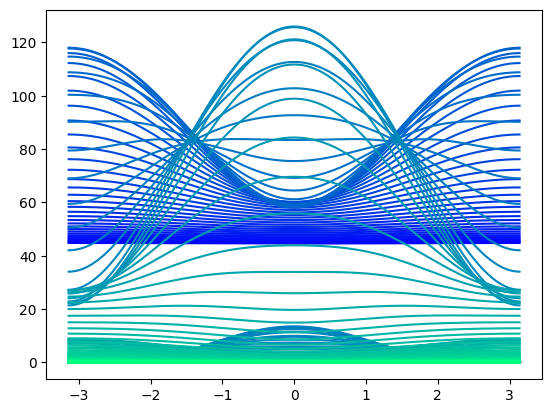

In [37]:
colormap = plt.cm.get_cmap('winter', len(g_range))

for n,g in enumerate(g_range):
    color = colormap(n)
    plt.plot(k_range,spectrum_slice[3,n,:,:], color=color)

In [45]:
#spectrum by copying the functions pietro wrote in Mathematica, where do they come from? 
a_range = np.arange(0.01,2,0.1)
g_range = np.arange(-2,2,0.05) 
krange = np.arange(-np.pi,np.pi,0.01)
eiglist1 = np.zeros((len(a_range),len(g_range),len(krange)))
eiglist2 = np.zeros((len(a_range),len(g_range),len(krange)))
eiglist3 = np.zeros((len(a_range),len(g_range),len(krange)))
eiglist4 = np.zeros((len(a_range),len(g_range),len(krange)))
a=1
g=0.5
for m,a in enumerate(tqdm(a_range)):
    
    for n,g in enumerate(g_range):

        for i,k in enumerate(krange):
            
            eigval1=np.sqrt(aa(k,a,g)**2 + b(k,a,g)**2 + 2*eta(k,a,g)**(2) +2*np.abs(eps(k,a,g))**2)
            eigval2=np.sqrt((aa(k,a,g)**2 - b(k,a,g)**2)**(2) +4*(aa(k,a,g) - b(k,a,g))**(2)*np.abs(eps(k,a,g))**2
            +4*(aa(k,a,g) + b(k,a,g))**(2)*np.abs(d(k,a,g))**(2) + 8*np.abs(d(k,a,g))**(2)*np.abs(eps(k,a,g))**(2) +16*eta(k,a,g)**(2)*np.abs(d(k,a,g))**2 + 16*(aa(k,a,g)-b(k,a,g))*eta(k,a,g)*np.real(eps(k,a,g)*np.conj(d(k,a,g))))
            eiglist1[m,n,i]=eigval1+eigval2
            eiglist2[m,n,i]=eigval1-eigval2
            eiglist3[m,n,i]=-eigval1+eigval2
            eiglist4[m,n,i]=-eigval1-eigval2
    #print(eiglist[i])
#plt.plot(krange,eiglist1,c='r')
#plt.plot(krange,eiglist2,c='b')
#plt.plot(krange,eiglist3,c='g')
#plt.plot(krange,eiglist4,c='y')

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.63s/it]


In [742]:

#g_range[7 and 8] we observe some gap closings and crossings
print(a_range[30],g_range[13])


1.51 -0.8499999999999994


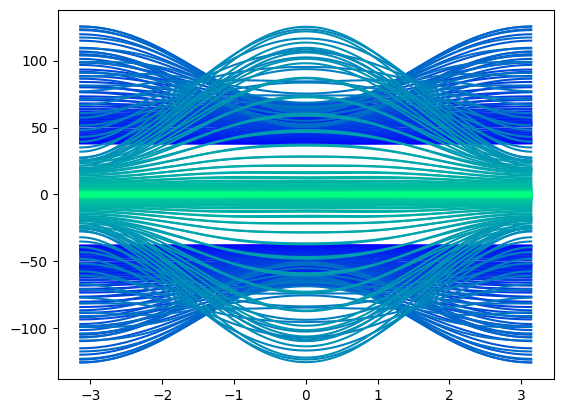

In [50]:
#for a=3 ca. and g_range[7 and 8] we observe some gap closings and crossings, there are probably others 
m=3 #fix alpha 
colormap = plt.cm.get_cmap('winter', len(g_range))
for n in range(len(g_range)):
    color = colormap(n)
    plt.plot(krange,eiglist1[m,n,:],color=color)
    
    plt.plot(krange,eiglist2[m,n,:],color=color)
    
    plt.plot(krange,eiglist3[m,n,:],color=color)
    
    plt.plot(krange,eiglist4[m,n,:],color=color)

In [73]:
k_res=0.01
a_range = np.arange(0.01,2,0.1)
g_range = np.arange(-2,2,0.05) 
k_range = np.arange(-np.pi,np.pi,0.01)

A_1 = np.zeros((len(a_range),len(g_range)), dtype='c16')


for m,a in enumerate(tqdm(a_range)):
    
    for n,g in enumerate(g_range):
        
        v=np.zeros(len(k_range),dtype='c16')
        
        for i,k in enumerate(k_range):
            
            offdiag1=magic@H(k+k_res,a,g)@np.conj(magic.T)
            offdiag2=magic@H(k-k_res,a,g)@np.conj(magic.T)
            
            _,der1=(np.linalg.slogdet(offdiag1))
            _,der2=(np.linalg.slogdet(offdiag2))
            v[i]=(1/(2*k_res))*(der1-der2)
                      
            
        vtot=(1/2*np.pi*1j)*k_res*np.sum(v,axis=0)
        A_1[m,n]=vtot

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.38s/it]


Text(0, 0.5, '$\\gamma$')

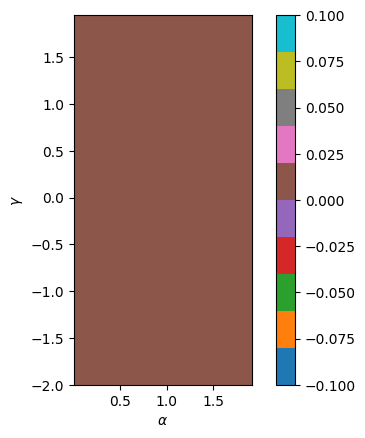

In [75]:
#trying to integrate logdetv(k) where v is the offdiagonal block after magic rotation 

x,y = a_range,g_range
grid=np.real(np.flipud(A_1))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='none',cmap='tab10')
#,vmin=,vmax=
fig.colorbar(cax)
#pixel_plot = plt.imshow(
#  np.real(data), cmap='twilight', interpolation='none')
plt.xlabel(r'$\alpha$')  
plt.ylabel(r'$\gamma$')


In [335]:
import pyperclip

In [336]:
copied_data = pyperclip.paste()

In [339]:
from sympy import symbols, Matrix, sympify


In [4]:
def epsilon(tau,k):
    epsilon= np.arctan((np.sqrt(np.sin(tau/2)**(4)*np.sin(2*k)**(2)+np.sin(tau)**(2)*np.cos(k)**(2))
                       )/(np.cos(tau/2)**(2)-np.sin(tau/2)**(2)*np.cos(2*k)))
    
    return epsilon

In [9]:
print(epsilon(np.pi,1))
print(len(k_range))

1.1415926535897931
629


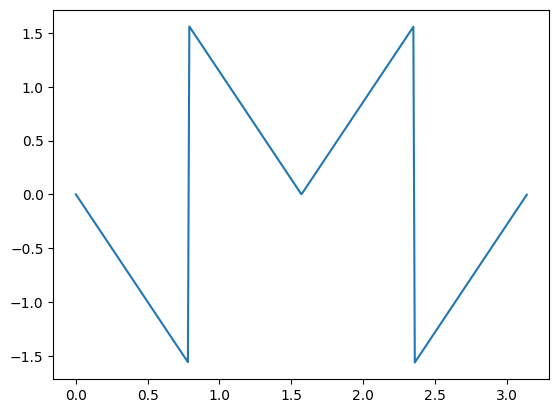

In [7]:
k_res = 0.01
tau = np.pi  #transition at pi/2=1.57
k_range = np.arange(0, np.pi, k_res)
spectrum = np.zeros(len(k_range))
for i,k in enumerate(k_range):
    spectrum[i]=epsilon(tau,k)
    
plt.plot(k_range,spectrum)